In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

# Read API key from file
with open('/content/drive/My Drive/ML4T/api_keys.json', 'r') as f:
    api_keys = json.load(f)
    QUANDL_API_KEY = api_keys['QUANDL_API_KEY']

# Set the environment variable
%env QUANDL_API_KEY=$QUANDL_API_KEY

In [ ]:
# Download the TA-Lib source files from the official source using wget.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the tar.gz file to access the source files.
!tar -xvzf ta-lib-0.4.0-src.tar.gz

# Change the directory to the extracted folder to run configuration and installation commands.
%cd ta-lib

# Configure the installation of TA-Lib for the system.
!./configure --prefix=/usr

# Compile the TA-Lib source files.
!make

# Install the compiled TA-Lib to the system directory.
!sudo make install

# Navigate back to the parent directory after installation is complete.
%cd ../

# Install the TA-Lib Python wrapper which allows the use of TA-Lib within Python scripts.
!pip install TA-Lib

!pip install zipline-reloaded
!pip install alphalens-reloaded
!pip install pyfolio-reloaded
!zipline ingest -b quandl
!pip install logbook
!pip install pyportfolioopt

In [3]:
from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

# Mean-Variance Optimization

Mean-Variance Optimization (MVO) is a fundamental concept in modern portfolio theory. It aims to construct an optimal portfolio by balancing the trade-off between expected returns and risk. The key objective is to:

1. Minimize portfolio volatility for a given level of expected return, or
2. Maximize expected returns for a given level of volatility

This approach, pioneered by Harry Markowitz, revolutionized portfolio management by introducing a quantitative framework for diversification.

## Key Concepts

- **Expected Returns**: The anticipated average return of each asset
- **Standard Deviation**: A measure of an asset's volatility or risk
- **Covariance Matrix**: Captures the relationships between asset returns
- **Efficient Frontier**: The set of optimal portfolios that offer the highest expected return for a defined level of risk

The portfolio variance, which we aim to minimize, is defined as:

$$\sigma^2_{PF} = \omega^T \Sigma \omega$$

Where:
- $\omega$: Vector of portfolio weights
- $\Sigma$: Covariance matrix of asset returns

The optimization problem can be formulated as:

$$
\begin{align*}
\min_\omega \quad & \sigma^2_{PF} = \omega^T \Sigma \omega \\
\text{subject to} \quad & \mu_{PF} = \omega^T \mu \\
& \|\omega\| = 1
\end{align*}
$$

Where:
- $\mu_{PF}$ is the target expected portfolio return
- $\mu$ is the vector of expected returns for individual assets

This formulation allows us to find the optimal portfolio weights that minimize risk for a given level of expected return, subject to the constraint that the weights sum to 1.

In this notebook, we'll implement MVO using historical data and explore its implications for portfolio construction.

In [4]:
# Imports & Settings

import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages

import numpy as np
import pandas as pd
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Set the style for our plots
sns.set_style('whitegrid')

# Set a random seed for reproducibility
np.random.seed(42)

# Create a diverging color palette for later use in heatmaps
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We'll use historical data for stocks included in the S&P 500 from 1998 to 2017. This dataset provides a good representation of the US stock market over a significant period, including both bull and bear markets.

In [6]:
# Load S&P 500 stock data from an HDF5 file
with pd.HDFStore(HDF_PATH) as store:
    sp500_stocks = store['sp500/stocks']

In [7]:
# Display the first few rows of the S&P 500 stocks data
print(sp500_stocks.head())

               name                     gics_sector        gics_sub_industry  \
ticker                                                                         
MMM              3M        Industrial Conglomerates    Saint Paul, Minnesota   
AOS     A. O. Smith               Building Products     Milwaukee, Wisconsin   
ABT          Abbott           Health Care Equipment  North Chicago, Illinois   
ABBV         AbbVie                   Biotechnology  North Chicago, Illinois   
ACN       Accenture  IT Consulting & Other Services          Dublin, Ireland   

       headquarters  date_added          cik  
ticker                                        
MMM      1957-03-04       66740         1902  
AOS      2017-07-26       91142         1916  
ABT      1957-03-04        1800         1888  
ABBV     2012-12-31     1551152  2013 (1888)  
ACN      2011-07-06     1467373         1989  


In [8]:
# Load price data for a sample of 30 S&P 500 stocks
with pd.HDFStore(HDF_PATH) as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

# The resulting 'prices' DataFrame contains daily adjusted closing prices
# for 30 randomly selected S&P 500 stocks

## Compute Inputs

To perform mean-variance optimization, we need to calculate the following inputs:
1. Expected returns for each asset
2. Covariance matrix of asset returns

We'll use historical data to estimate these parameters.

In [9]:
# Set the start and end years for our analysis
start = 2008
end = 2017

# Calculate weekly returns and drop any dates with no observations
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)

# Display information about the weekly returns DataFrame
print(weekly_returns.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PPG     521 non-null    float64
 1   ZBRA    521 non-null    float64
 2   NDAQ    521 non-null    float64
 3   NSC     521 non-null    float64
 4   PG      521 non-null    float64
 5   HRL     521 non-null    float64
 6   DOV     521 non-null    float64
 7   DOW     521 non-null    float64
 8   MTB     521 non-null    float64
 9   RF      521 non-null    float64
 10  RL      521 non-null    float64
 11  EQR     521 non-null    float64
 12  IPG     521 non-null    float64
 13  FCX     521 non-null    float64
 14  CL      521 non-null    float64
 15  ED      521 non-null    float64
 16  CRL     521 non-null    float64
 17  GILD    521 non-null    float64
 18  CMI     521 non-null    float64
 19  ALL     521 non-null    float64
 20  PWR     521 non-null    float64
 21  AME     

In [10]:
# Extract the list of stock tickers
stocks = weekly_returns.columns

# Get the number of observations and assets
n_obs, n_assets = weekly_returns.shape
print(f"Number of observations: {n_obs}, Number of assets: {n_assets}")

Number of observations: 521, Number of assets: 25


In [11]:
# Set the number of portfolios to simulate
NUM_PF = 100000  # Number of portfolios to simulate

# Generate initial random weights
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))  # Normalize to ensure weights sum to 1

# Calculate the annualization factor
periods_per_year = round(weekly_returns.resample('A').size().mean())
print(f"Periods per year: {periods_per_year}")

Periods per year: 52


In [12]:
# Compute mean returns and covariance matrix
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

# Compute the precision matrix (inverse of covariance matrix)
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

# Load historical 10-year Treasury rate as the risk-free rate
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

# Calculate the average risk-free rate
rf_rate = treasury_10yr_monthly.mean()
print(f"Average risk-free rate: {rf_rate:.4f}")

Average risk-free rate: 0.0005


## Simulate Random Portfolios

To get a sense of the possible combinations of risk and return, we'll simulate a large number of random portfolios. This will help us visualize the feasible set of portfolios and provide context for our optimized portfolios.

In [13]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    """
    Simulate a large number of random portfolios to visualize the feasible set.

    Parameters:
    - mean_ret: Mean returns of assets
    - cov: Covariance matrix of asset returns
    - rf_rate: Risk-free rate
    - short: Boolean indicating whether short-selling is allowed

    Returns:
    - DataFrame of portfolio performances
    - Array of portfolio weights
    """
    # Set concentration parameter for Dirichlet distribution
    alpha = np.full(shape=n_assets, fill_value=.05)

    # Generate random weights using Dirichlet distribution
    weights = dirichlet(alpha=alpha, size=NUM_PF)

    # If short-selling is allowed, randomly flip signs of weights
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    # Calculate annualized returns
    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1

    # Calculate annualized standard deviation
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)

    # Calculate Sharpe ratio
    sharpe = (returns - rf_rate) / std

    return pd.DataFrame({
        'Annualized Standard Deviation': std,
        'Annualized Returns': returns,
        'Sharpe Ratio': sharpe
    }), weights

# Simulate portfolios
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

# Display summary statistics of the simulated weights
print(pd.DataFrame(simul_wt).describe())

                  0              1              2              3   \
count   1.000000e+05   1.000000e+05   1.000000e+05   1.000000e+05   
mean    3.971877e-02   3.975610e-02   3.966743e-02   4.034702e-02   
std     1.300849e-01   1.307336e-01   1.306797e-01   1.312285e-01   
min    3.195118e-117  2.610741e-113  1.453611e-109  1.365811e-112   
25%     7.281044e-13   6.059444e-13   6.874859e-13   6.126182e-13   
50%     7.334836e-07   6.875117e-07   6.560785e-07   7.580676e-07   
75%     2.426300e-03   2.339421e-03   2.326850e-03   2.464383e-03   
max     9.992341e-01   9.965880e-01   9.997105e-01   9.998588e-01   

                  4              5             6              7   \
count   1.000000e+05   1.000000e+05  1.000000e+05   1.000000e+05   
mean    4.022327e-02   4.056676e-02  3.962842e-02   4.051160e-02   
std     1.313580e-01   1.320921e-01  1.296675e-01   1.312301e-01   
min    2.066476e-137  2.435011e-122  1.142838e-99  1.893105e-105   
25%     6.313019e-13   6.667453e-13  6

## Visualize Simulated Portfolios

Now that we have simulated a large number of random portfolios, we can visualize them to get an intuition about the range of possible risk-return combinations. This will also help us identify the empirical efficient frontier.

Max Sharpe: SD = 14.64%, Return = 19.24%


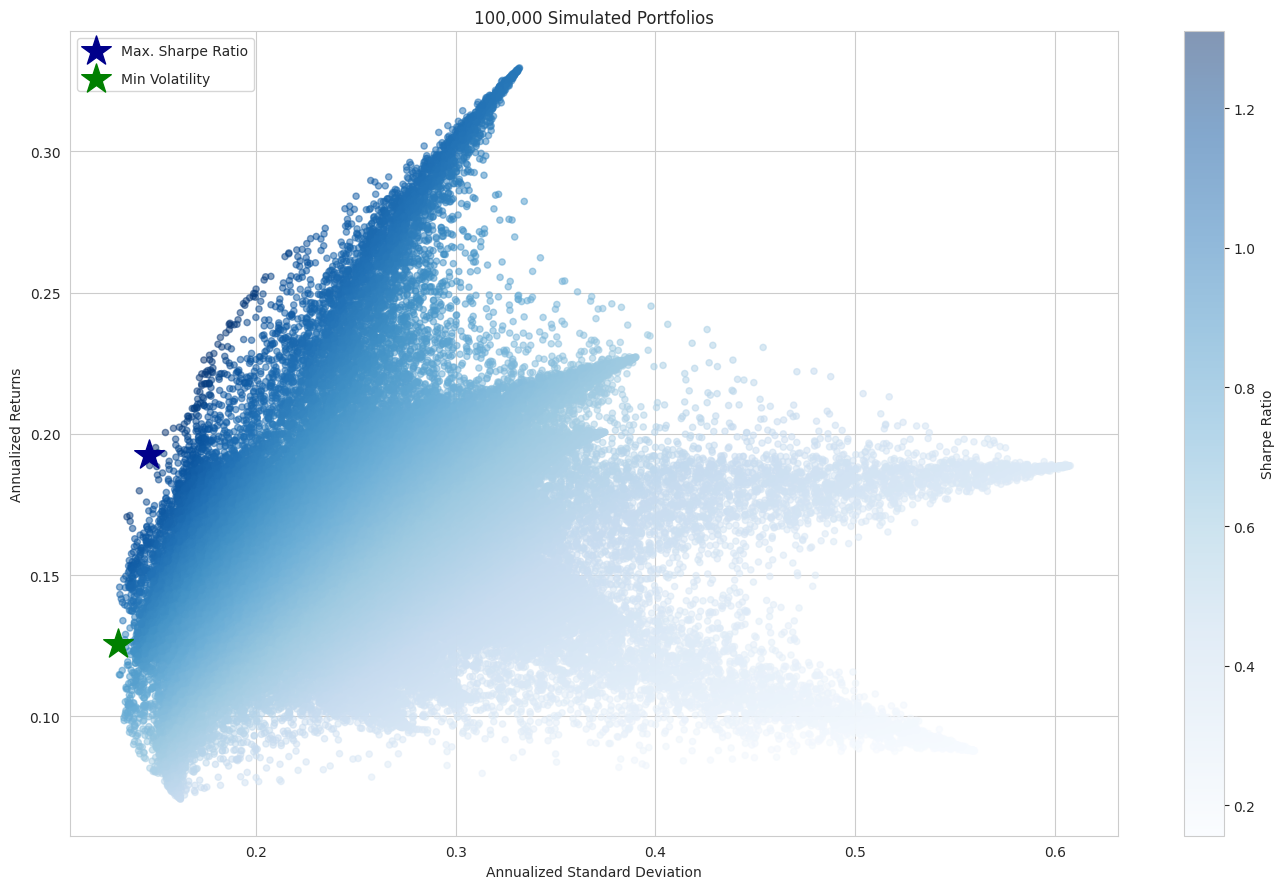

In [14]:
# Plot the simulated portfolios
ax = simul_perf.plot.scatter(
    x='Annualized Standard Deviation',
    y='Annualized Returns',
    c='Sharpe Ratio',
    cmap='Blues',
    alpha=0.5,
    figsize=(14, 9),
    colorbar=True,
    title=f'{NUM_PF:,d} Simulated Portfolios'
)

# Identify and plot the portfolio with maximum Sharpe ratio
max_sharpe_idx = simul_perf['Sharpe Ratio'].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: SD = {sd:.2%}, Return = {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

# Identify and plot the minimum volatility portfolio
min_vol_idx = simul_perf['Annualized Standard Deviation'].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')

plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()
plt.show()

## Compute Annualized PF Performance

Now we'll set up the functions to calculate key portfolio performance metrics. These functions will be used in our optimization process to evaluate different portfolio configurations.

In [17]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    # Calculate the annualized portfolio standard deviation
    # wt: array of portfolio weights
    # cov: covariance matrix of asset returns
    # periods_per_year: number of periods in a year (for annualization)
    return np.sqrt(wt @ cov @ wt * periods_per_year)

def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    # Calculate the annualized portfolio return
    # wt: array of portfolio weights
    # rt: array of mean returns for each asset
    # periods_per_year: number of periods in a year (for annualization)
    return (wt @ rt + 1) ** periods_per_year - 1

def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    # Calculate both annualized return and standard deviation for a portfolio
    # wt: array of portfolio weights
    # rt: array of mean returns for each asset
    # cov: covariance matrix of asset returns
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

We'll now define the objective function for maximizing the Sharpe ratio. The Sharpe ratio measures the risk-adjusted return of a portfolio. We'll use the negative Sharpe ratio as our objective function because optimization algorithms typically minimize the objective.

In [18]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    # Calculate the negative Sharpe ratio for optimization
    # weights: array of portfolio weights
    # mean_ret: array of mean returns for each asset
    # cov: covariance matrix of asset returns
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

# Define the constraint that weights must sum to 1
weight_constraint = {'type': 'eq',
                     'fun': lambda x: np.sum(np.abs(x))-1}

def max_sharpe_ratio(mean_ret, cov, short=False):
    # Find the portfolio weights that maximize the Sharpe ratio
    # mean_ret: array of mean returns for each asset
    # cov: covariance matrix of asset returns
    # short: boolean flag to allow (True) or disallow (False) short selling
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The efficient frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk. We'll compute this by finding the minimum volatility portfolio for a range of target returns.

In [19]:
def min_vol_target(mean_ret, cov, target, short=False):
    # Find the minimum volatility portfolio for a given target return
    # mean_ret: array of mean returns for each asset
    # cov: covariance matrix of asset returns
    # target: target return
    # short: boolean flag to allow (True) or disallow (False) short selling

    def ret_(wt):
        # Helper function to calculate portfolio return
        return portfolio_returns(wt, mean_ret)

    # Define constraints:
    # 1. Portfolio return must equal the target
    # 2. Weights must sum to 1
    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    # Set bounds for weights based on whether short selling is allowed
    bounds = ((-1 if short else 0, 1),) * n_assets

    # Minimize the portfolio standard deviation
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

def efficient_frontier(mean_ret, cov, ret_range, short=False):
    # Compute the efficient frontier for a range of target returns
    # mean_ret: array of mean returns for each asset
    # cov: covariance matrix of asset returns
    # ret_range: array of target returns
    # short: boolean flag to allow (True) or disallow (False) short selling
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Min Volatility Portfolio

In addition to the maximum Sharpe ratio portfolio, investors are often interested in the portfolio with the lowest overall risk. We'll implement a function to find this minimum volatility portfolio.

In [20]:
def min_vol(mean_ret, cov, short=False):
    # Find the portfolio with minimum volatility
    # mean_ret: array of mean returns for each asset
    # cov: covariance matrix of asset returns
    # short: boolean flag to allow (True) or disallow (False) short selling

    # Set bounds for weights based on whether short selling is allowed
    bounds = ((-1 if short else 0, 1),) * n_assets

    # Minimize the portfolio standard deviation
    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

## Run Calculation

Now that we have defined all our functions, let's put them to use. We'll calculate the random portfolios, find the maximum Sharpe ratio portfolio, compute the efficient frontier, and identify the minimum volatility portfolio.

In [21]:
# Get random portfolios
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

print(simul_perf.describe())

# Find the portfolio with the maximum Sharpe ratio from our simulations
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
print(simul_perf.iloc[simul_max_sharpe])

# Get Max Sharpe PF using optimization
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

# Display the results of the maximum Sharpe ratio portfolio
r, sd = max_sharpe_perf
print(pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd}))

# Get Min Vol PF
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

# Get Efficient Frontier
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.265324            0.163228       0.642524
std                         0.067369            0.034239       0.170618
min                         0.127571            0.070820       0.156210
25%                         0.227030            0.141796       0.535360
50%                         0.260451            0.164095       0.635573
75%                         0.295706            0.181998       0.737024
max                         0.607835            0.329523       1.313735
Annualized Standard Deviation    0.151394
Annualized Returns               0.199391
Sharpe Ratio                     1.313735
Name: 23106, dtype: float64
ret    0.201090
sd     0.148689
sr     1.349067
dtype: float64


## Visualize Results

Now that we have computed various optimal portfolios and the efficient frontier, let's visualize all these results together. This visualization will help us understand the relationship between risk and return for our portfolios and identify the optimal solutions.

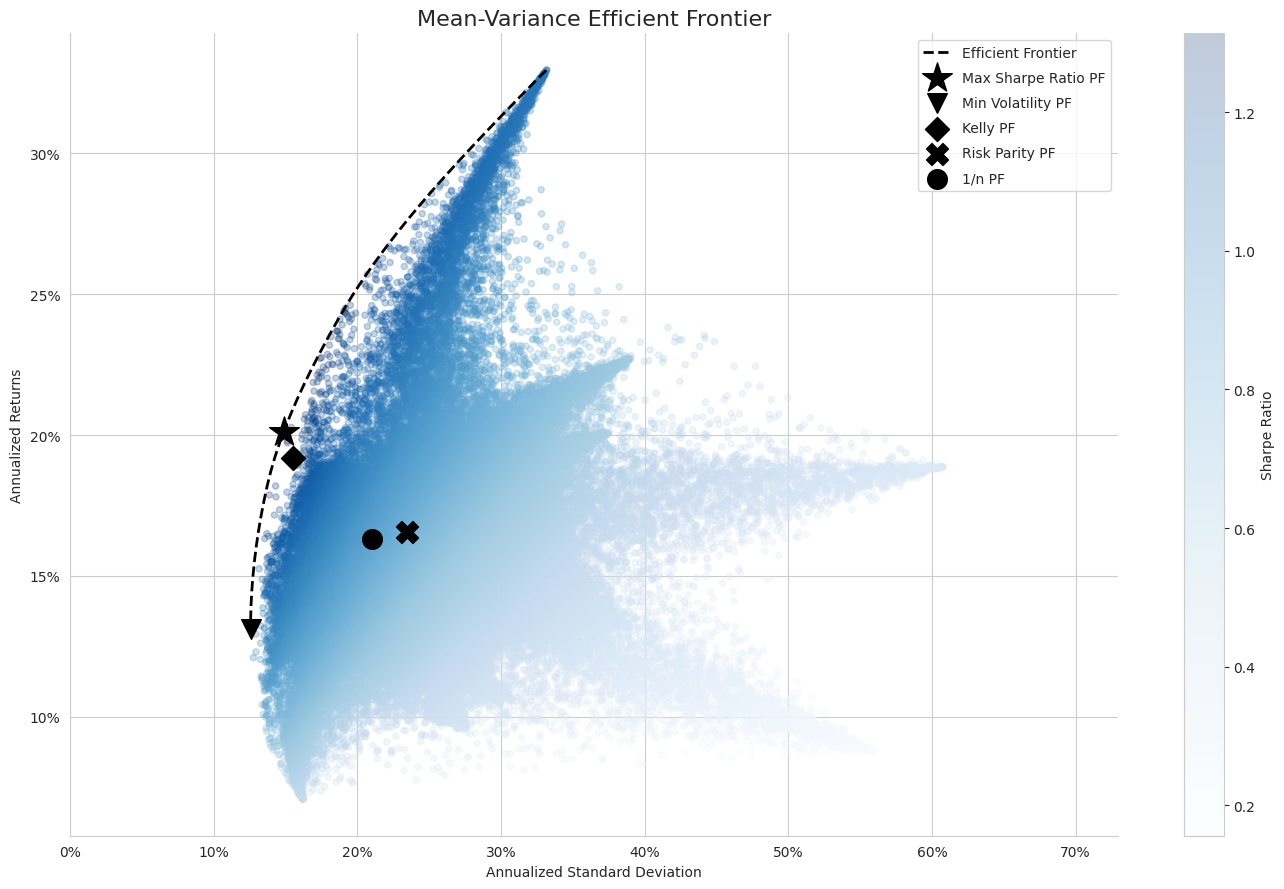

In [22]:
# Create a new figure and axis for our plot
fig, ax = plt.subplots()

# Plot all the simulated portfolios
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25,
                        figsize=(14, 9), colorbar=True)

# Plot the efficient frontier
eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

# Plot the maximum Sharpe ratio portfolio
r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

# Plot the minimum volatility portfolio
r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

# Calculate and plot the Kelly portfolio
kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

# Calculate and plot the risk parity portfolio
std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

# Calculate and plot the equal-weight portfolio
r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')

# Customize the plot
ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout()

# Display the plot
plt.show()

# Interpreting the Mean-Variance Efficient Frontier Plot

This plot visualizes key concepts in Modern Portfolio Theory:

1. **Simulated Portfolios**: The blue dots represent thousands of simulated portfolios. Their position shows the trade-off between risk (x-axis) and return (y-axis). The color intensity indicates the Sharpe ratio, with darker blue suggesting higher risk-adjusted returns.

2. **Efficient Frontier**: The dashed black line represents the set of optimal portfolios that offer the highest expected return for a given level of risk. Portfolios on this line are considered efficient.

3. **Max Sharpe Ratio Portfolio**: Marked by a star, this portfolio offers the best risk-adjusted return. It's located at the point where a line from the risk-free rate would tangent to the efficient frontier.

4. **Minimum Volatility Portfolio**: Represented by a triangle, this is the portfolio with the lowest overall risk on the efficient frontier.

5. **Kelly Portfolio**: Shown as a diamond, this portfolio aims to maximize long-term growth rate.

6. **Risk Parity Portfolio**: Marked by an X, this portfolio equalizes risk contribution from each asset.

7. **Equal Weight (1/n) Portfolio**: Depicted by a circle, this simple strategy invests equally in all assets.

Key observations:
- The efficient frontier forms the upper edge of the "cloud" of possible portfolios.
- Portfolios below the efficient frontier are suboptimal - one can achieve a higher return for the same risk, or lower risk for the same return.
- The Max Sharpe Ratio portfolio typically offers a balanced trade-off between risk and return.
- The Kelly and Risk Parity portfolios often offer alternative optimization approaches that may be more robust to estimation errors.

This visualization helps investors understand the risk-return characteristics of different portfolio construction strategies and their relationship to the theoretical optimum represented by the efficient frontier.